### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

# to track progress of the learning
from tqdm import trange

import time
import os
import sys

In [2]:
random.seed(17)
np.random.seed(17)

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
def encode_track_state(state):
    return ('-'.join(str(e) for e in state))

In [5]:
def encode_track_action(action):
    return ('-'.join(str(e) for e in action))

In [6]:
# Tracking q-values for all possible moves for state (4-4-2)
def initialise_tracking_states(episodes): 
    sample_q_values = [('4-4-2', f"{p}-{q}") for p in range(6) for q in range(6) if ((p>0 and q>0 and p!=q) or (p==0 and q==0))]  

    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []

In [7]:
def save_tracking_states(curr_state, curr_action, curr_q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(curr_q_value)
      

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001 
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.00005
        self.epsilon_min = 0.0001
        
        self.batch_size = 64        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        
         
        # input layer - input dimension would be state size
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        # layer - 2
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # layer - 3
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output size is total number of possible actions     
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        # model.summary

        return model


    def update_target_model(self):
        # update the target Q-value network to current Q-value network after training for a episode. 
        # this means that weights an biases of target Q-value network will become same as current Q-value network.
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state, possible_actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment   

        if np.random.rand() <= self.epsilon_max:
            # exploration
            return random.choice(possible_actions)
        else:
            # exploitation
            q_values = self.model.predict(state)
            
            possible_action_q_values = list(q_values[0][index] for index in possible_actions)
            max_q_value = np.max(possible_action_q_values)
            choice = np.where(q_values[0] == max_q_value)
            return choice[0][0]
        


    def append_sample(self, state, action, reward, next_state, terminal):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done = mini_batch[i]
                
                
                # Write your code from here

                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(done)
                update_output[i] = next_state

            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.target_model.predict(update_output)  
            
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # 4. Fit your model and track the loss values
            # used 20 epoch to train the model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=20, verbose=0)
        


    def save(self, name):
        self.model.save(name)
      
    def get_model_weights(self):
        return self.model.get_weights()

In [10]:
Episodes = 4000

### DQN block

In [11]:
env = CabDriver()

scores = []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
States_track = collections.defaultdict(dict)
initialise_tracking_states(Episodes)

In [12]:
value = "Score : {0}, Rides : {1}, ε : {2}, memory : {3}".format(0, 0, agent.epsilon_max, len(agent.memory))

t_range = trange(Episodes, desc=value, leave=True)

for episode in t_range:

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0
    current_day = 0

    #Call the DQN agent
    action_space, state_space, state = env.reset()
    track_state = state
    
    rides = 0
    while not terminal_state:
        
        # Write your code here

        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])

        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions, action_list = env.requests(state)
        action = agent.get_action(state_encoded, possible_actions)
        
        

        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        

        # 3. Append the experience to the memory
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
     
        score += reward
        previous_day = state[2]
        current_day = next_state[2]
        state = next_state

        rides += 1
        
        if previous_day != current_day:
            total_days = total_days + 1
            
        if total_days > 30:
            terminal_state = True
            scores.append(score)
            agent.update_target_model()

        # 4. Train the model by calling function agent.train_model
        # Train the model every 50 trips
        if rides%50 == 0:
            agent.train_model()

    # 5. Keep a track of rewards, Q-values, loss
    # Track q-value convergence
    # once the episode is complete, q-values will be predicted for all possible actions for the initial state
    track_state_encode = encode_track_state(track_state)
    track_state_encoded = env.state_encod_arch1(track_state)
    track_state_encoded = np.reshape(track_state_encoded, [1, state_size])

    track_q_values = agent.model.predict(track_state_encoded)[0]
    
    for index in range(len(env.action_space)):
        track_action_encode = encode_track_action(env.action_space[index])
        save_tracking_states(track_state_encode, track_action_encode, track_q_values[index])
    
    #save model
    if (episode + 1) % 100 == 0:
        PATH = "models"
        if not os.path.exists(PATH):
            os.mkdir(PATH)
        # save the pickle file generated
        save_obj(agent.get_model_weights(), os.path.join(PATH,f"cardriver_dqn_{score}_{rides}_e{episode+1}"))
      
    agent.epsilon_max = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay*episode)
    
    
    value = "Score : {0}, Rides : {1}, ε : {2}, memory : {3}".format(score, rides, agent.epsilon_max, len(agent.memory))
    t_range.set_description(value)
    t_range.refresh() # to show immediately the update

Score : 1582.0, Rides : 107, ε : 0.00010000000000000003, memory : 2000: 100%|██████████| 4000/4000 [4:58:08<00:00,  4.47s/it]  


### Tracking Convergence

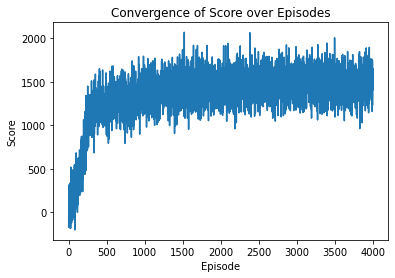

In [13]:
# convergence with scores
plt.plot(range(Episodes), scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Convergence of Score over Episodes")
plt.show()

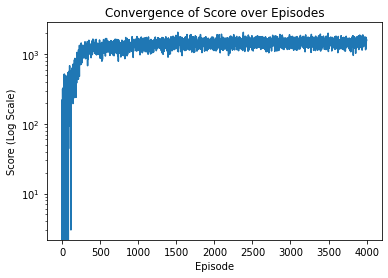

In [14]:
# convergence with scores (log)
plt.plot(range(Episodes), scores)
plt.yscale("log")
plt.xlabel("Episode")
plt.ylabel("Score (Log Scale)")
plt.title("Convergence of Score over Episodes")
plt.show()

In [15]:
# maximum score at episode
print(f"Maximum Score --> {scores[np.argmax(scores)]} at Episode --> {np.argmax(scores)}")

Maximum Score --> 2068.0 at Episode --> 1519


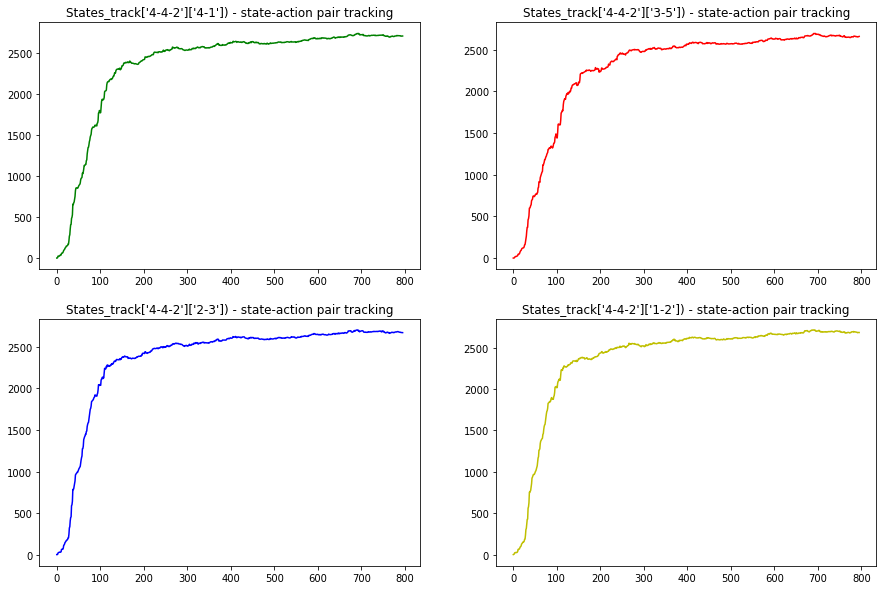

In [24]:
# plotting the graphs for state-action pairs tracked

plt.figure(0, figsize=(15,10))


plt.subplot(221)
plt.title("States_track['4-4-2']['4-1']) - state-action pair tracking")
plt.plot(States_track['4-4-2']['4-1'], 'g')


plt.subplot(222)
plt.title("States_track['4-4-2']['3-5']) - state-action pair tracking")
plt.plot(States_track['4-4-2']['3-5'], 'r')

plt.subplot(223)
plt.title("States_track['4-4-2']['2-3']) - state-action pair tracking")
plt.plot(States_track['4-4-2']['2-3'], 'b')

plt.subplot(224)
plt.title("States_track['4-4-2']['1-2']) - state-action pair tracking")
plt.plot(States_track['4-4-2']['1-2'], 'y')

plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [19]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

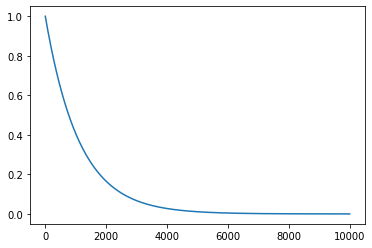

In [20]:
plt.plot(time, epsilon)
plt.show()